# Mesh dependency of axis-symmetric bubbles velocities and shapes

Four bubbles are investigated:
- bubbles in aqueous sugar solutions (Bhaga & Weber 1981)
    - dimpled ellipsoidal $Eo=243$, $Mo=266$, $Ga^\prime=80$
    - spherical cap (closed wake) $Eo=115$, $Mo=4.63\times 10^{-3}$, $Ga^\prime = 135$
    - skirted (smooth) $Eo = 339$, $Mo=43.1$, $Ga^\prime = 30.8$
- a small bubble in water at 20°C, $Mo=2.5728\times 10^{-11}$
    - $d_{eq}=1.8~mm$ corresponding to $Eo=0.4361$, $Ga^\prime = 238.29$
    
The shapes are compared at time instances for which the shapes are steady (mostly). The mesh size was varied by setting the maximum allowed refinement level to 14, 15, and 16.

In [1]:
import glob

data_path = "../data/"
bhaga_cases = glob.glob(data_path + "bhaga_0*")
water_cases = glob.glob(data_path + "water_05_l*")
cases = sorted(bhaga_cases + water_cases)
for i, case in enumerate(cases):
    print(i, case)

0 ../data/bhaga_02_l14
1 ../data/bhaga_02_l15
2 ../data/bhaga_02_l16
3 ../data/bhaga_03_l14
4 ../data/bhaga_03_l15
5 ../data/bhaga_03_l16
6 ../data/bhaga_04_l14
7 ../data/bhaga_04_l15
8 ../data/bhaga_04_l16
9 ../data/water_05_l14
10 ../data/water_05_l15
11 ../data/water_05_l16


In [2]:
import pandas as pd
import numpy as np

class VelocityProfile():
    
    def __init__(self, path=None, ga=None):
        self.path = path
        self.ga = ga
        self.read_velocity_profile()
        
    def read_velocity_profile(self):
        '''Method to extract the velocity profiles from log files.
           - removes duplicates, removes error messages, and sortes entries with respect to time
        '''
        log_files = glob.glob(self.path + "/err*")
        if not log_files: print("No log-files found in {}".format(self.path))
        names = ['time', 'volume', 'x', 'y', 'z', 'u_x', 'u_y', 'u_z', 'omega_x', 'omega_y', 'omega_z', 'area']
        usecols = ['time', 'u_x', 'x', 'area', 'volume']
        log_df = []
        for file in sorted(log_files):
            try:
                raw_log = pd.read_csv(file, sep=' ', header=None, names=names, usecols=usecols)
                clean_log = raw_log[pd.to_numeric(raw_log.time, errors='coerce').isnull() == False].reset_index(drop=True)
                log_df.append(clean_log.apply(pd.to_numeric))
            except Exception as read_exc:
                print("Error reading data from disk for file \033[1m{}\033[0m".format(file))
        full_log = pd.concat(log_df)
        full_log.drop_duplicates("time", inplace=True)
        self.data = full_log.reset_index(drop=True)
        
        
    def get_re_profile(self):
        return self.data['time'].values, self.data['u_x'].values * self.ga
    
    
    def get_re_mean(self, t_start, t_end):
        re = self.data[(self.data['time'] >= t_start) & (self.data['time'] <= t_end)].u_x.values * self.ga
        return np.mean(re)
    
    def get_re_range(self, t_start, t_end):
        re = self.data[(self.data['time'] >= t_start) & (self.data['time'] <= t_end)].u_x.values * self.ga
        return np.amin(re), np.amax(re)
    
    def get_closest_re(self, time):
        row = self.data.iloc[(self.data['time']-time).abs().argsort()[:1]]
        return row.index.values, row.time.values, row.u_x.values * self.ga, row.x.values
    
        
bhaga_02_l14 = VelocityProfile(cases[0], ga=15.2400)
bhaga_02_l15 = VelocityProfile(cases[1], ga=15.2400)
bhaga_02_l16 = VelocityProfile(cases[2], ga=15.2400)
bhaga_03_l14 = VelocityProfile(cases[3], ga=134.626)
bhaga_03_l15 = VelocityProfile(cases[4], ga=134.626)
bhaga_03_l16 = VelocityProfile(cases[5], ga=134.626)
bhaga_04_l14 = VelocityProfile(cases[6], ga=30.8340)
bhaga_04_l15 = VelocityProfile(cases[7], ga=30.8340)
bhaga_04_l16 = VelocityProfile(cases[8], ga=30.8340)
water_01_l14 = VelocityProfile(cases[9], ga=98.6715)
water_01_l15 = VelocityProfile(cases[10], ga=98.6715)
water_01_l16 = VelocityProfile(cases[11], ga=98.6715)
water_02_l16 = VelocityProfile(cases[12], ga=129.707)
water_03_l14 = VelocityProfile(cases[13], ga=163.450)
water_03_l15 = VelocityProfile(cases[14], ga=163.450)
water_03_l16 = VelocityProfile(cases[15], ga=163.450)
water_04_l16 = VelocityProfile(cases[16], ga=199.697)
water_05_l14 = VelocityProfile(cases[17], ga=238.287)
water_05_l15 = VelocityProfile(cases[18], ga=238.287)
water_05_l16 = VelocityProfile(cases[19], ga=238.287)

In [3]:
def read_shape(path, iteration):
    ''' Helper function to read PLIC intersections points from disk.
        The files are named as points_iteration_nprocessor.txt. The
        function reads all avaialable processor files und concatenates them.
        
    Parameters
    ----------
    path - String: relative path to the file location
    iteration - Integer: iteration to load
    
    Returns
    -------
    px, py - array-like: two arrays containing the x and y values of all points
    '''
    base_name = path + "/points_{:06d}_n".format(iteration)
    files = sorted(glob.glob(base_name + "*"))
    points = []
    columns = ["px", "py"]
    for file in files:
        points.append(pd.read_csv(file, sep=" ", names=columns, skip_blank_lines=True))
    all_points = pd.concat(points)
    return all_points.px.values, all_points.py.values

In [4]:
# some general parameters for plotting
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
line_width = 2.0
fontsize_ticks = 18.0
fontsize_labels = 22.0

## Bhaga 03 - spherical cap (closed wake)

[43, 177, 415, 773, 8959]


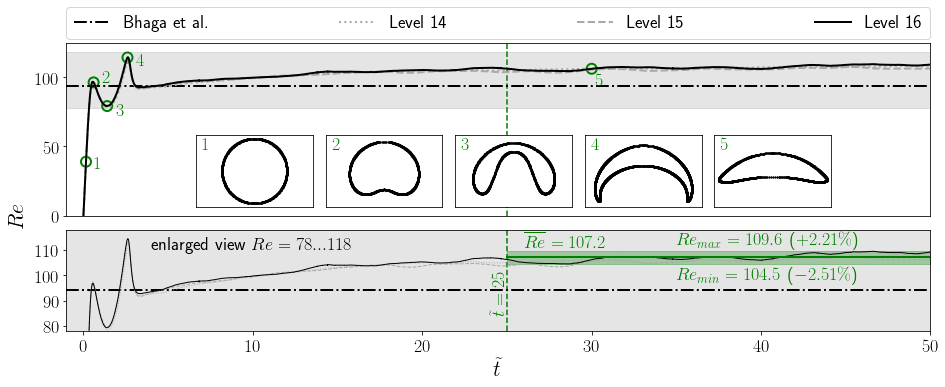

In [5]:
# axis limits and zoom window definition
t_min = -1.0
t_max = 50.0
tw_min = 25.0
tw_max = 50.0
re_zoom_min = 78.0
re_zoom_max = 118.0
l16_mean = bhaga_03_l16.get_re_mean(tw_min, tw_max)
l16_min, l16_max = bhaga_03_l16.get_re_range(tw_min, tw_max)

# create basis for upper part of the plot
ax1 = plt.axes([0.0, 0.4, 2.0, 0.6], xticks=[], xlim=[t_min, t_max], ylim=[0, 125])
ax1.fill_between([-1, 120], [re_zoom_min, re_zoom_min], [re_zoom_max, re_zoom_max], color='k', alpha=0.1)
ax1.tick_params(labelsize=fontsize_ticks)
ax1.axvline(25, 0, 1, linestyle='--', color='g')
ax1.text(-4.5, 0, r"$Re$", va='center', rotation='vertical', fontsize=fontsize_labels)

# create basis for lower part of the plot
ax2 = plt.axes([0.0, 0.0, 2.0, 0.35], yticks=[80, 90, 100, 110], xlim=[t_min, t_max], ylim=[re_zoom_min, re_zoom_max])
ax2.patch.set_facecolor('k')
ax2.patch.set_alpha(0.1)
ax2.set_xlabel(r"$\tilde{t}$", fontsize=fontsize_labels)
ax2.tick_params(labelsize=fontsize_ticks)
ax2.plot([25, 50], [l16_mean, l16_mean], color='g')
ax2.fill_between([25, 50], [l16_min, l16_min], [l16_max, l16_max], color='g', alpha=0.3)
ax2.axvline(25, 0, 1, linestyle='--', color='g')

# reference curve Bhaga and Weber 1981
lines = []
lines.append(ax1.plot([t_min, t_max], [94.0, 94.0], linestyle='-.', lw=line_width, color='k', label="Bhaga et al.")[0])
ax2.plot([t_min, t_max], [94.0, 94.0], linestyle='-.', lw=line_width, color='k')

# plot the numerical data in both sub-plots
styles = [':', '--', '-']
colors = ["darkgrey", "darkgrey", "black"]
labels = ["Level 14", "Level 15", "Level 16"]
for i, level in enumerate([bhaga_03_l14, bhaga_03_l15, bhaga_03_l16]):
    t, re = level.get_re_profile()
    lines.append(ax1.plot(t, re, color=colors[i], linestyle=styles[i], lw=line_width, label=labels[i])[0])
    ax2.plot(t, re, color=colors[i], linestyle=styles[i], lw=line_width*0.5)

# include bubbles shapes of selected time instances (snap shots) into the upper plot
iter_snap = []
t_snap = []
re_snap = []
center_snap = []
for t in [0.15, 0.6, 1.4, 2.6, 30.0]:
    it, t_c, re, center = bhaga_03_l16.get_closest_re(t)
    iter_snap.append(it[0])
    t_snap.append(t_c[0])
    re_snap.append(re[0])
    center_snap.append(center[0])
# mark time instances with circles
ax1.scatter(t_snap, re_snap, marker='o', s=100, facecolors='none', edgecolors='g', linewidth=2)
offset_t = [0.5, 0.5, 0.5, 0.5, 0.2]
offset_re = [-5., 0., -7., -6., -12.]
print(iter_snap)
# draw shapes
for i, t in enumerate(t_snap):
    ax1.text(t_snap[i]+offset_t[i], re_snap[i]+offset_re[i], r"${}$".format(i+1), color="g", fontsize=fontsize_ticks)
    ax = plt.axes([0.3*(i+1), 0.42, 0.27, 0.27], xticks=[], yticks=[], xlim=[-0.9, 0.9], ylim=[-0.55, 0.55])
    ax.set_aspect('equal')
    px_i, py_i = read_shape(bhaga_03_l16.path, iter_snap[i]*10)
    ax.scatter(py_i, px_i-center_snap[i], s=1, color='k')
    ax.scatter(-py_i, px_i-center_snap[i], s=1, color='k')
    ax.text(ax.get_xlim()[0]*0.9, ax.get_ylim()[1]*0.6, r"${}$".format(i+1), color="g", fontsize=fontsize_ticks)
    
# indicate statistical values in the lower plot (mean, min, max of finest mesh)
ax2.plot([25, 50], [l16_mean, l16_mean], color='g', lw=line_width)
ax2.text(35, 97, r"$Re_{{min}}={:.1f}$ (${:+.2f}\%$)".format(l16_min, (l16_min-l16_mean)/l16_mean*100), fontsize=fontsize_ticks, color='g')
ax2.text(35, 111, r"$Re_{{max}}={:.1f}$ (${:+.2f}\%$)".format(l16_max, (l16_max-l16_mean)/l16_mean*100), fontsize=fontsize_ticks, color='g')
ax2.text(26, 111, r"$\overline{{Re}}={:.1f}$".format(l16_mean), fontsize=fontsize_ticks, color='g')
ax2.text(24, 96, r"$\tilde{{t}}={:.0f}$".format(tw_min), rotation='vertical', fontsize=fontsize_ticks, color='g')
ax2.text(4, 110, r"enlarged view $Re={:.0f}...{:.0f}$".format(re_zoom_min, re_zoom_max), fontsize=fontsize_ticks, color='k')

# create legend and save plot
ax1.legend(handles=lines, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0., fontsize=fontsize_ticks)
plt.savefig("bhaga_03.png", bbox_inches='tight')
plt.show()

## Bhaga 02 - dimpled ellipsoidal

mean/min/max:  8.377242269965642 8.3321427972 8.4033734904
relative min/max:  -0.5383570310164512 0.311931057885776
[0.16848707, 1.00194932, 2.4005848, 10.00097466, 29.99951267]
[32, 203, 490, 2090, 6207]


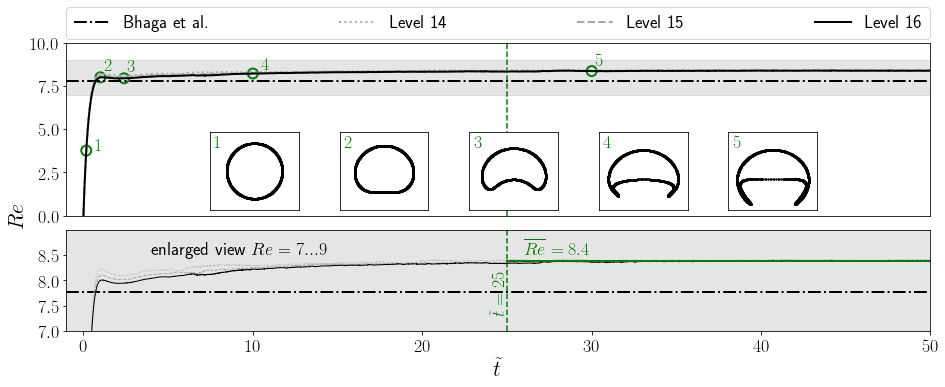

In [6]:
# axis limits and zoom window definition
t_min = -1.0
t_max = 50.0
tw_min = 25.0
tw_max = 50.0
re_zoom_min = 7.0
re_zoom_max = 9.0
l16_mean = bhaga_02_l16.get_re_mean(tw_min, tw_max)
l16_min, l16_max = bhaga_02_l16.get_re_range(tw_min, tw_max)
print("mean/min/max: ", l16_mean, l16_min, l16_max)
print("relative min/max: ", (l16_min-l16_mean)/l16_mean*100, (l16_max-l16_mean)/l16_mean*100)

# create basis for upper part of the plot
ax1 = plt.axes([0.0, 0.4, 2.0, 0.6], xticks=[], xlim=[t_min, t_max], ylim=[0, 10])
ax1.fill_between([-1, 120], [re_zoom_min, re_zoom_min], [re_zoom_max, re_zoom_max], color='k', alpha=0.1)
ax1.tick_params(labelsize=fontsize_ticks)
ax1.axvline(25, 0, 1, linestyle='--', color='g')
ax1.text(-4.5, 0, r"$Re$", va='center', rotation='vertical', fontsize=fontsize_labels)

# create basis for lower part of the plot
ax2 = plt.axes([0.0, 0.0, 2.0, 0.35], yticks=[7.0, 7.5, 8.0, 8.5], xlim=[t_min, t_max], ylim=[re_zoom_min, re_zoom_max])
ax2.patch.set_facecolor('k')
ax2.patch.set_alpha(0.1)
ax2.set_xlabel(r"$\tilde{t}$", fontsize=fontsize_labels)
ax2.tick_params(labelsize=fontsize_ticks)
ax2.plot([25, 50], [l16_mean, l16_mean], color='g')
ax2.axvline(25, 0, 1, linestyle='--', color='g')

# reference curve Bhaga and Weber 1981
lines = []
lines.append(ax1.plot([t_min, t_max], [7.77, 7.77], linestyle='-.', lw=line_width, color='k', label="Bhaga et al.")[0])
ax2.plot([t_min, t_max], [7.77, 7.77], linestyle='-.', lw=line_width, color='k')

# plot the numerical data in both sub-plots
styles = [':', '--', '-']
colors = ["darkgrey", "darkgrey", "black"]
labels = ["Level 14", "Level 15", "Level 16"]
for i, level in enumerate([bhaga_02_l14, bhaga_02_l15, bhaga_02_l16]):
    t, re = level.get_re_profile()
    lines.append(ax1.plot(t, re, color=colors[i], linestyle=styles[i], lw=line_width, label=labels[i])[0])
    ax2.plot(t, re, color=colors[i], linestyle=styles[i], lw=line_width*0.5)

# include bubbles shapes of selected time instances (snap shots) into the upper plot
iter_snap = []
t_snap = []
re_snap = []
center_snap = []
for t in [0.17, 1.0, 2.4, 10.0, 30.0]:
    it, t_c, re, center = bhaga_02_l16.get_closest_re(t)
    iter_snap.append(it[0])
    t_snap.append(t_c[0])
    re_snap.append(re[0])
    center_snap.append(center[0])
# mark time instances with circles
ax1.scatter(t_snap, re_snap, marker='o', s=100, facecolors='none', edgecolors='g', linewidth=2)
offset_t = [0.5, 0.2, 0.2, 0.5, 0.2]
offset_re = [-0., 0.4, 0.4, 0.2, 0.3]
print(t_snap)
print(iter_snap)
# draw shapes
for i, t in enumerate(t_snap):
    ax1.text(t_snap[i]+offset_t[i], re_snap[i]+offset_re[i], r"${}$".format(i+1), color="g", fontsize=fontsize_ticks)
    ax = plt.axes([0.3*(i+1), 0.42, 0.27, 0.27], xticks=[], yticks=[], xlim=[-0.8, 0.8], ylim=[-0.7, 0.7])
    ax.set_aspect('equal')
    px_i, py_i = read_shape(bhaga_02_l16.path, iter_snap[i]*10)
    ax.scatter(py_i, px_i-center_snap[i], s=1, color='k')
    ax.scatter(-py_i, px_i-center_snap[i], s=1, color='k')
    ax.text(ax.get_xlim()[0]*0.9, ax.get_ylim()[1]*0.6, r"${}$".format(i+1), color="g", fontsize=fontsize_ticks)
    
# indicate statistical values in the lower plot (mean of finest mesh)
ax2.plot([25, 50], [l16_mean, l16_mean], color='g', lw=line_width)
ax2.text(26, 8.5, r"$\overline{{Re}}={:.1f}$".format(l16_mean), fontsize=fontsize_ticks, color='g')
ax2.text(24, 7.9, r"$\tilde{{t}}={:.0f}$".format(tw_min), rotation='vertical', fontsize=fontsize_ticks, color='g')
ax2.text(4, 8.5, r"enlarged view $Re={:.0f}...{:.0f}$".format(re_zoom_min, re_zoom_max), fontsize=fontsize_ticks, color='k')

# create legend and save plot
ax1.legend(handles=lines, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0., fontsize=fontsize_ticks)
plt.savefig("bhaga_02.png", bbox_inches='tight')
plt.show()

## Bhaga 04 - skirted (stable)

[0.17158531, 0.79908497, 2.8025331, 19.99839797, 39.99900398]
[28, 137, 485, 3638, 7466]


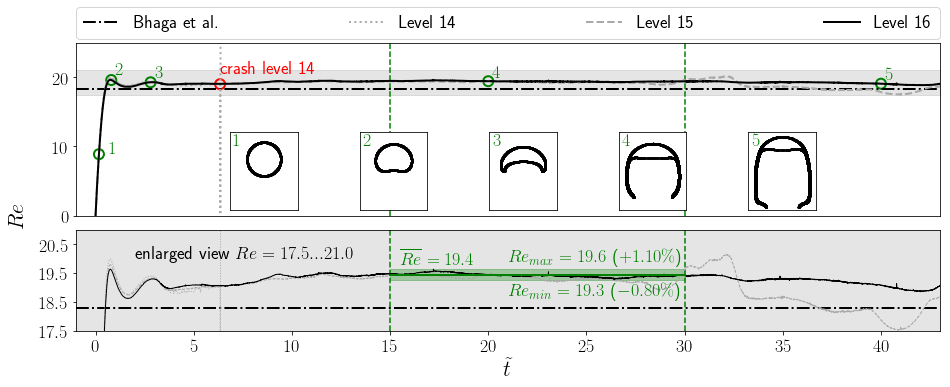

In [7]:
# axis limits and zoom window definition
t_min = -1.0
t_max = 43.0
tw_min = 15.0
tw_max = 30.0
re_zoom_min = 17.5
re_zoom_max = 21.0
l16_mean = bhaga_04_l16.get_re_mean(tw_min, tw_max)
l16_min, l16_max = bhaga_04_l16.get_re_range(tw_min, tw_max)

# create basis for upper part of the plot
ax1 = plt.axes([0.0, 0.4, 2.0, 0.6], xticks=[], xlim=[t_min, t_max], ylim=[0, 25])
ax1.fill_between([t_min, t_max], [re_zoom_min, re_zoom_min], [re_zoom_max, re_zoom_max], color='k', alpha=0.1)
ax1.tick_params(labelsize=fontsize_ticks)
ax1.axvline(15, 0, 1, linestyle='--', color='g')
ax1.axvline(30, 0, 1, linestyle='--', color='g')
ax1.text(-4.5, 0, r"$Re$", va='center', rotation='vertical', fontsize=fontsize_labels)

# create basis for lower part of the plot
ax2 = plt.axes([0.0, 0.0, 2.0, 0.35], yticks=[17.5, 18.5, 19.5, 20.5], xlim=[t_min, t_max], ylim=[re_zoom_min, re_zoom_max])
ax2.patch.set_facecolor('k')
ax2.patch.set_alpha(0.1)
ax2.set_xlabel(r"$\tilde{t}$", fontsize=fontsize_labels)
ax2.tick_params(labelsize=fontsize_ticks)
ax2.fill_between([tw_min, tw_max], [l16_min, l16_min], [l16_max, l16_max], color='g', alpha=0.3)
ax2.axvline(15, 0, 1, linestyle='--', color='g')
ax2.axvline(30, 0, 1, linestyle='--', color='g')

# reference curve Bhaga and Weber 1981
lines = []
lines.append(ax1.plot([t_min, t_max], [18.3, 18.3], linestyle='-.', lw=line_width, color='k', label="Bhaga et al.")[0])
ax2.plot([t_min, t_max], [18.3, 18.3], linestyle='-.', lw=line_width, color='k')

# plot the numerical data in both sub-plots
styles = [':', '--', '-']
colors = ["darkgrey", "darkgrey", "black"]
labels = ["Level 14", "Level 15", "Level 16"]
for i, level in enumerate([bhaga_04_l14, bhaga_04_l15, bhaga_04_l16]):
    t, re = level.get_re_profile()
    lines.append(ax1.plot(t, re, color=colors[i], linestyle=styles[i], lw=line_width, label=labels[i])[0])
    ax2.plot(t, re, color=colors[i], linestyle=styles[i], lw=line_width*0.5)

# include bubbles shapes of selected time instances (snap shots) into the upper plot
iter_snap = []
t_snap = []
re_snap = []
center_snap = []
for t in [0.17, 0.8, 2.8, 20.0, 40.0]:
    it, t_c, re, center = bhaga_04_l16.get_closest_re(t)
    iter_snap.append(it[0])
    t_snap.append(t_c[0])
    re_snap.append(re[0])
    center_snap.append(center[0])
# mark time instances with circles
ax1.scatter(t_snap, re_snap, marker='o', s=100, facecolors='none', edgecolors='g', linewidth=2)
offset_t = [0.5, 0.2, 0.2, 0.2, 0.2]
offset_re = [-0., 0.7, 0.7, 0.5, 0.6]
print(t_snap)
print(iter_snap)
# draw shapes
for i, t in enumerate(t_snap):
    ax1.text(t_snap[i]+offset_t[i], re_snap[i]+offset_re[i], r"${}$".format(i+1), color="g", fontsize=fontsize_ticks)
    ax = plt.axes([0.3*(i+1), 0.42, 0.27, 0.27], xticks=[], yticks=[], xlim=[-1.0, 1.0], ylim=[-1.5, 0.8])
    ax.set_aspect('equal')
    px_i, py_i = read_shape(bhaga_04_l16.path, iter_snap[i]*10)
    ax.scatter(py_i, px_i-center_snap[i], s=1, color='k')
    ax.scatter(-py_i, px_i-center_snap[i], s=1, color='k')
    ax.text(ax.get_xlim()[0]*0.9, ax.get_ylim()[1]*0.5, r"${}$".format(i+1), color="g", fontsize=fontsize_ticks)
    
# indicate statistical values in the lower plot (mean of finest mesh)
ax2.plot([tw_min, tw_max], [l16_mean, l16_mean], color='g', lw=line_width)
ax2.text(21, 18.6, r"$Re_{{min}}={:.1f}$ (${:+.2f}\%$)".format(l16_min, (l16_min-l16_mean)/l16_mean*100), fontsize=fontsize_ticks, color='g')
ax2.text(21, 19.8, r"$Re_{{max}}={:.1f}$ (${:+.2f}\%$)".format(l16_max, (l16_max-l16_mean)/l16_mean*100), fontsize=fontsize_ticks, color='g')
ax2.text(15.5, 19.8, r"$\overline{{Re}}={:.1f}$".format(l16_mean), fontsize=fontsize_ticks, color='g')
ax2.text(2, 20.0, r"enlarged view $Re={:.1f}...{:.1f}$".format(re_zoom_min, re_zoom_max), fontsize=fontsize_ticks, color='k')

# indicate crash of level 14 simulation
ax1.scatter(6.34, 0.6166*bhaga_04_l14.ga, marker='o', s=100, facecolors='none', edgecolors='r', linewidth=2)
ax1.text(6.34, 20.5, r"crash level 14", fontsize=fontsize_ticks, color='r')

# create legend and save plot
ax1.legend(handles=lines, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0., fontsize=fontsize_ticks)
plt.savefig("bhaga_04.png", bbox_inches='tight')
plt.show()

## Water 05 (1.8mm diameter, 20°C)

mean/min/max:  658.5255017858569 655.94099353944 662.8190643939901
relative min/max:  -0.39246896884144905 0.651996406591606
[0.4999176, 2.00008261, 5.00002065, 8.99993805, 10.99989675]
[2420, 9684, 24210, 43578, 53264]


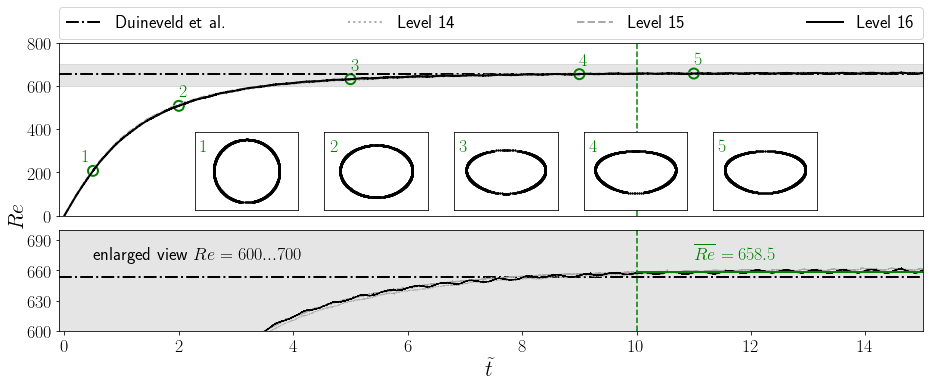

In [8]:
# axis limits and zoom window definition
t_min = -0.1
t_max = 15.0
tw_min = 10.0
tw_max = 15.0
re_zoom_min = 600.0
re_zoom_max = 700.0
l16_mean = water_05_l16.get_re_mean(tw_min, tw_max)
l16_min, l16_max = water_05_l16.get_re_range(tw_min, tw_max)
print("mean/min/max: ", l16_mean, l16_min, l16_max)
print("relative min/max: ", (l16_min-l16_mean)/l16_mean*100, (l16_max-l16_mean)/l16_mean*100)

# create basis for upper part of the plot
ax1 = plt.axes([0.0, 0.4, 2.0, 0.6], xticks=[], xlim=[t_min, t_max], ylim=[0, 800])
ax1.fill_between([t_min, t_max], [re_zoom_min, re_zoom_min], [re_zoom_max, re_zoom_max], color='k', alpha=0.1)
ax1.tick_params(labelsize=fontsize_ticks)
ax1.axvline(10, 0, 1, linestyle='--', color='g')
ax1.text(-1.0, 0, r"$Re$", va='center', rotation='vertical', fontsize=fontsize_labels)

# create basis for lower part of the plot
ax2 = plt.axes([0.0, 0.0, 2.0, 0.35], yticks=[600, 630, 660, 690], xlim=[t_min, t_max], ylim=[re_zoom_min, re_zoom_max])
ax2.patch.set_facecolor('k')
ax2.patch.set_alpha(0.1)
ax2.set_xlabel(r"$\tilde{t}$", fontsize=fontsize_labels)
ax2.tick_params(labelsize=fontsize_ticks)
ax2.axvline(10, 0, 1, linestyle='--', color='g')

# reference curve Bhaga and Weber 1981
lines = []
lines.append(ax1.plot([t_min, t_max], [653.64, 653.64], linestyle='-.', lw=line_width, color='k', label="Duineveld et al.")[0])
ax2.plot([t_min, t_max], [653.64, 653.64], linestyle='-.', lw=line_width, color='k')

# plot the numerical data in both sub-plots
styles = [':', '--', '-']
colors = ["darkgrey", "darkgrey", "black"]
labels = ["Level 14", "Level 15", "Level 16"]
for i, level in enumerate([water_05_l14, water_05_l15, water_05_l16]):
    t, re = level.get_re_profile()
    lines.append(ax1.plot(t, re, color=colors[i], linestyle=styles[i], lw=line_width, label=labels[i])[0])
    ax2.plot(t, re, color=colors[i], linestyle=styles[i], lw=line_width*0.5)

# include bubbles shapes of selected time instances (snap shots) into the upper plot
iter_snap = []
t_snap = []
re_snap = []
center_snap = []
for t in [0.5, 2.0, 5.0, 9.0, 11.0]:
    it, t_c, re, center = water_05_l16.get_closest_re(t)
    iter_snap.append(it[0])
    t_snap.append(t_c[0])
    re_snap.append(re[0])
    center_snap.append(center[0])
# mark time instances with circles
ax1.scatter(t_snap, re_snap, marker='o', s=100, facecolors='none', edgecolors='g', linewidth=2)
offset_t = [-0.2, 0.0, 0.0, 0.0, 0.0]
offset_re = [40, 40, 40, 40, 40]
print(t_snap)
print(iter_snap)
# draw shapes
for i, t in enumerate(t_snap):
    ax1.text(t_snap[i]+offset_t[i], re_snap[i]+offset_re[i], r"${}$".format(i+1), color="g", fontsize=fontsize_ticks)
    ax = plt.axes([0.3*(i+1), 0.42, 0.27, 0.27], xticks=[], yticks=[], xlim=[-0.8, 0.8], ylim=[-0.6, 0.6])
    ax.set_aspect('equal')
    px_i, py_i = read_shape(water_05_l16.path, iter_snap[i]*10)
    ax.scatter(py_i, px_i-center_snap[i], s=1, color='k')
    ax.scatter(-py_i, px_i-center_snap[i], s=1, color='k')
    ax.text(ax.get_xlim()[0]*0.9, ax.get_ylim()[1]*0.5, r"${}$".format(i+1), color="g", fontsize=fontsize_ticks)
    
# indicate statistical values in the lower plot (mean of finest mesh)
ax2.plot([tw_min, tw_max], [l16_mean, l16_mean], color='g', lw=line_width)
ax2.text(11.0, 670, r"$\overline{{Re}}={:.1f}$".format(l16_mean), fontsize=fontsize_ticks, color='g')
ax2.text(0.5, 670, r"enlarged view $Re={:.0f}...{:.0f}$".format(re_zoom_min, re_zoom_max), fontsize=fontsize_ticks, color='k')

# create legend and save plot
ax1.legend(handles=lines, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0., fontsize=fontsize_ticks)
plt.savefig("water_05.png", bbox_inches='tight')
plt.show()

# Mesh dependency of bubble shapes

In [5]:
# find iterations corresponding to time for comparison
shape_info = {}
for level in [bhaga_02_l14, bhaga_02_l15, bhaga_02_l16]:
    it, t_c, re, center = level.get_closest_re(30.0)
    shape_info[level.path.split('/')[-1]] = [it[0], t_c[0], re[0], center[0]]
for level in [bhaga_03_l14, bhaga_03_l15, bhaga_03_l16]:
    it, t_c, re, center = level.get_closest_re(30.0)
    shape_info[level.path.split('/')[-1]] = [it[0], t_c[0], re[0], center[0]]
for level in [bhaga_04_l15, bhaga_04_l16]:
    it, t_c, re, center = level.get_closest_re(20.0)
    shape_info[level.path.split('/')[-1]] = [it[0], t_c[0], re[0], center[0]]
for level in [water_05_l14, water_05_l15, water_05_l16]:
    it, t_c, re, center = level.get_closest_re(11.0)
    shape_info[level.path.split('/')[-1]] = [it[0], t_c[0], re[0], center[0]]
    
for key in shape_info.keys():
    print(key, shape_info[key])

bhaga_02_l14 [1322, 29.99851985, 8.4062657376, 19.72572256]
bhaga_02_l15 [2720, 30.00384445, 8.370109752000001, 19.63219274]
bhaga_02_l16 [6207, 29.99951267, 8.3629437516, 19.57088588]
bhaga_03_l14 [1139, 29.99731903, 106.36246408636, 25.79844654]
bhaga_03_l15 [3181, 30.00189573, 105.5864582822, 25.75826207]
bhaga_03_l16 [8959, 29.99932931, 106.22127372260002, 25.93888942]
bhaga_04_l15 [1670, 20.00222138, 19.43947167048, 15.84176152]
bhaga_04_l16 [3638, 19.99839797, 19.44475415136, 15.87381194]
water_05_l14 [6659, 11.00016521, 657.40236243591, 29.9414048]
water_05_l15 [18832, 11.00005841, 659.25738622212, 30.0585292]
water_05_l16 [53264, 10.99989675, 657.81788730651, 29.98171945]


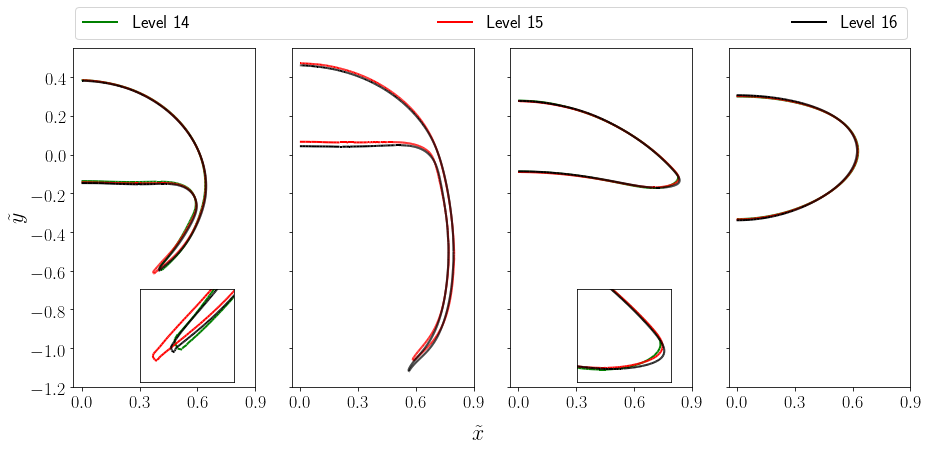

In [30]:
from matplotlib import collections  as mc
from copy import copy
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 6.5), sharey=True, sharex=True)

line_styles = ['-', '-', '-']
line_color = ["green", "red", "black"]
labels = ['Level 14', 'Level 15', 'Level 16']
line_width = [2, 2, 2]
alpha = [1.0, 1.0, 1.0]
line_legend = []

# first plot: bhaga_02
ax1_zoom = plt.axes([0.13, 0.15, 0.2, 0.2], xticks=[], yticks=[], xlim=[0.35, 0.5], ylim=[-0.65, -0.5])
ax1_zoom.set_aspect('equal')
for i, name in enumerate(["bhaga_02_l14", "bhaga_02_l15", "bhaga_02_l16"]):
    it, _, _, x = shape_info[name]
    px, py = read_shape("./data/"+name, it*10)
    lines = []
    for j in range(0, len(px)-1, 2):
        lines.append([(py[j], px[j]-x), (py[j+1], px[j+1]-x)])
    lc = mc.LineCollection(lines, colors=line_color[i], linewidths=line_width[i],
                           linestyle=line_styles[i], label=labels[i], alpha=alpha[i])
    line_legend.append(lc)
    lcc = copy(lc)
    ax1.add_collection(lc)
    ax1.autoscale()
    ax1_zoom.add_collection(lcc)

    
# second plot: bhaga_04
for i, name in enumerate(["bhaga_04_l15", "bhaga_04_l16"]):
    it, _, _, x = shape_info[name]
    px, py = read_shape("./data/"+name, it*10)
    lines = []
    for j in range(0, len(px)-1, 2):
        lines.append([(py[j], px[j]-x), (py[j+1], px[j+1]-x)])
    lc = mc.LineCollection(lines, colors=line_color[i+1], linewidths=line_width[i+1],
                           linestyle=line_styles[i+1], alpha=alpha[i+1])
    ax2.add_collection(lc)
    ax2.autoscale()
    
# third plot: bhaga_03
ax3_zoom = plt.axes([0.535, 0.15, 0.2, 0.2], xticks=[], yticks=[], xlim=[0.65, 0.85], ylim=[-0.2, 0.0])
ax3_zoom.set_aspect('equal')
for i, name in enumerate(["bhaga_03_l14", "bhaga_03_l15", "bhaga_03_l16"]):
    it, _, _, x = shape_info[name]
    px, py = read_shape("./data/"+name, it*10)
    lines = []
    for j in range(0, len(px)-1, 2):
        lines.append([(py[j], px[j]-x), (py[j+1], px[j+1]-x)])
    lc = mc.LineCollection(lines, colors=line_color[i], linewidths=line_width[i],
                           linestyle=line_styles[i], alpha=alpha[i])
    lcc = copy(lc)
    ax3.add_collection(lc)
    ax3.autoscale()
    ax3_zoom.add_collection(lcc)
    
# fourth plot: water_05
for i, name in enumerate(["water_05_l14", "water_05_l15", "water_05_l16"]):
    it, _, _, x = shape_info[name]
    px, py = read_shape("./data/"+name, it*10)
    lines = []
    for j in range(0, len(px)-1, 2):
        lines.append([(py[j], px[j]-x), (py[j+1], px[j+1]-x)])
    lc = mc.LineCollection(lines, colors=line_color[i], linewidths=line_width[i],
                           linestyle=line_styles[i], alpha=alpha[i])
    ax4.add_collection(lc)
    ax4.autoscale()
    
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_aspect('equal')
    ax.tick_params(labelsize=fontsize_ticks)
    ax.set_xticks([0.0, 0.3, 0.6, 0.9])
    
fig.text(0.5, 0.04, r"$\tilde{x}$", ha='center', va='center', fontsize=fontsize_labels)
ax1.set_ylabel(r"$\tilde{y}$", fontsize=fontsize_labels)
ax1.legend(handles=line_legend, bbox_to_anchor=(0., 1.02, 4.59, .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.1, fontsize=fontsize_ticks)

plt.savefig("shapes.pdf", bbox_inches='tight')
plt.show()

In [6]:
# extract some times and iterations for shape analysis
it, t_c, re, center = bhaga_02_l16.get_closest_re(30.0)
print(bhaga_02_l16.path.split('/')[-1], it[0], t_c[0], re[0]/bhaga_02_l16.ga, center[0])
it, t_c, re, center = bhaga_03_l16.get_closest_re(30.0)
print(bhaga_03_l16.path.split('/')[-1], it[0], t_c[0], re[0]/bhaga_03_l16.ga, center[0])
it, t_c, re, center = bhaga_04_l16.get_closest_re(20.0)
print(bhaga_04_l16.path.split('/')[-1], it[0], t_c[0], re[0]/bhaga_04_l16.ga, center[0])
it, t_c, re, center = water_01_l16.get_closest_re(12.0)
print(water_01_l16.path.split('/')[-1], it[0], t_c[0], re[0]/water_01_l16.ga, center[0])
it, t_c, re, center = water_02_l16.get_closest_re(12.0)
print(water_02_l16.path.split('/')[-1], it[0], t_c[0], re[0]/water_02_l16.ga, center[0])
it, t_c, re, center = water_03_l16.get_closest_re(14.0)
print(water_03_l16.path.split('/')[-1], it[0], t_c[0], re[0]/water_03_l16.ga, center[0])
it, t_c, re, center = water_04_l16.get_closest_re(14.0)
print(water_04_l16.path.split('/')[-1], it[0], t_c[0], re[0]/water_04_l16.ga, center[0])
it, t_c, re, center = water_05_l16.get_closest_re(14.0)
print(water_05_l16.path.split('/')[-1], it[0], t_c[0], re[0]/water_05_l16.ga, center[0])

bhaga_02_l16 6207 29.99951267 0.54874959 19.57088588
bhaga_03_l16 8959 29.99932931 0.7890101 25.93888942
bhaga_04_l16 3638 19.99839797 0.63062704 15.87381194
water_01_l16 104590 12.00002295 2.93135279 34.28257266
water_02_l16 87163 11.99994493 3.11703751 35.94457315
water_03_l16 87161 13.99996788 3.07036012 41.86696306
water_04_l16 76261 14.00003672 2.93160608 40.18211259
water_05_l16 67792 14.0000413 2.76750992 38.27362914
